In [37]:
# Import the Altair library
# by convention, we use alt to save typing, but you can just 'import altair' if you wish
import altair as alt 
alt.data_transformers.enable('json') # work-around to let Altair handle larger data sets

import pandas as pd
import numpy as np
from altair import datum
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

In [2]:
#!pip install vega_datasets

In [3]:
from vega_datasets import data
countries = alt.topo_feature(data.world_110m.url, 'countries')
countries

UrlData({
  format: TopoDataFormat({
    feature: 'countries',
    type: 'topojson'
  }),
  url: 'https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/world-110m.json'
})

In [4]:
iso_country_codes = pd.read_csv('data/world.csv')
iso_country_codes['alpha3_MAJ'] = iso_country_codes['alpha3'].str.upper()
# iso_country_codes

In [5]:
# forest area 
forest_area_km = pd.read_csv('data/forest-area-km.csv')
# we divide areas by 10+6 to get readable numbers of the chart
forest_area_km['Forest area'] = forest_area_km['Forest area'] / 1_000_00

# forest density or forest cover
forest_cover  = pd.read_csv('data/forest-area-as-share-of-land-area.csv')
forest_area_km = forest_area_km.merge(forest_cover[['Code','Year','Forest cover']], how='left', on=['Code','Year'])

# drop duplicates
forest_area_km = forest_area_km.drop_duplicates(subset=['Entity','Year'], keep='first')
forest_area_km

,Entity,Code,Year,Forest area,Forest cover
0,Afghanistan,AFG,1990,12.0844,1.850994
1,Afghanistan,AFG,1991,12.0844,1.850994
2,Afghanistan,AFG,1992,12.0844,1.850994
3,Afghanistan,AFG,1993,12.0844,1.850994
4,Afghanistan,AFG,1994,12.0844,1.850994
...,...,...,...,...,...
44111,Zimbabwe,ZWE,2016,176.2886,45.570273
44112,Zimbabwe,ZWE,2017,175.8279,45.451183
44113,Zimbabwe,ZWE,2018,175.3672,45.332093
44114,Zimbabwe,ZWE,2019,174.9065,45.213002


In [6]:
new_forest = pd.DataFrame()
new_index = pd.RangeIndex(start=1990, stop=2020, step=1)
tmp_forest_list = []

In [7]:
def concatenate_spread_pct(df, col, suffix='_de', lag = 1, rounding=1):
    df[col + suffix] = np.round((df[col] - df[col].shift(lag)) / df[col] * 1000, rounding)
    return df

In [8]:
# there are some missing years
# we insert them and populate them with first a forward fill and then a backward fill
# in the meantime, we compute the year spread
new_forest = pd.DataFrame()
new_index = pd.RangeIndex(start=1990, stop=2020, step=1, name='Year')
tmp_forest_list = []

for entity in forest_area_km.Entity.unique():
    tmp_forest = pd.DataFrame()
    tmp_forest = forest_area_km[forest_area_km.Entity == entity]
    tmp_forest = tmp_forest.set_index('Year') \
                            .reindex(new_index) \
                            .fillna(method='ffill') \
                            .fillna(method='bfill') \
                            .reset_index()
    # Computing yearly variations
    tmp_forest = concatenate_spread_pct(tmp_forest, 'Forest area', suffix='_variation')
    tmp_forest = tmp_forest.fillna(0)
    # Computing index 100 = 1990
    [tmp_forest_baseline_area, tmp_forest_baseline_cover] = tmp_forest.loc[0,['Forest area','Forest cover']]
    tmp_forest['Forest base100'] = tmp_forest['Forest area'] / tmp_forest_baseline_area * 100
    #tmp_forest['Forest cover_base100'] = tmp_forest['Forest cover'] / tmp_forest_baseline_cover * 100
    #new_forest = pd.concat([new_forest,tmp_forest], axis=0)
    tmp_forest = tmp_forest.fillna(0)
    tmp_forest_list.append(tmp_forest)
new_forest = pd.concat(tmp_forest_list,axis=0)
new_forest['Forest area'] = np.round(new_forest['Forest area'],1)
new_forest['Forest cover'] = np.round(new_forest['Forest cover'],1)
new_forest['Forest area_variation'] = np.round(new_forest['Forest area_variation'],1)
new_forest['Forest base100'] = np.round(new_forest['Forest base100'],1)
new_forest

,Year,Entity,Code,Forest area,Forest cover,Forest area_variation,Forest base100
0,1990,Afghanistan,AFG,12.1,1.9,0.0,100.0
1,1991,Afghanistan,AFG,12.1,1.9,0.0,100.0
2,1992,Afghanistan,AFG,12.1,1.9,0.0,100.0
3,1993,Afghanistan,AFG,12.1,1.9,0.0,100.0
4,1994,Afghanistan,AFG,12.1,1.9,0.0,100.0
...,...,...,...,...,...,...,...
25,2015,Zimbabwe,ZWE,176.7,45.7,-2.6,93.9
26,2016,Zimbabwe,ZWE,176.3,45.6,-2.6,93.6
27,2017,Zimbabwe,ZWE,175.8,45.5,-2.6,93.4
28,2018,Zimbabwe,ZWE,175.4,45.3,-2.6,93.1


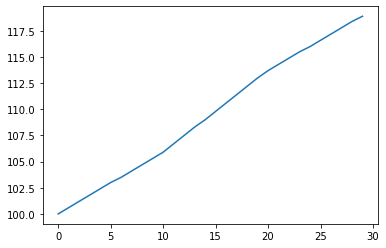

In [9]:
new_forest.loc[new_forest['Entity'] == 'France',	'Forest base100'].plot()

In [10]:
new_forest_ext = new_forest.merge(iso_country_codes, how='inner', right_on='alpha3_MAJ' , left_on='Code')
new_forest_ext['id'] = new_forest_ext['id'].astype(int)

new_forest_ext_year = new_forest_ext.groupby('Year').agg({'Forest area':'sum'})
new_forest_ext['Forest_area_pct_year'] = new_forest_ext.apply(
                                            lambda row: np.round(100 * row['Forest area']/ new_forest_ext_year.loc[row['Year'],'Forest area'],1),axis=1)
new_forest_ext['emoji'] = new_forest_ext['Forest_area_pct_year'].apply(lambda x : '🌳' * int(x) + ' ' + str(x) + '%')
filter_pct_area = 1.5

In [11]:
new_forest_ext['Forest area_variation'].describe()

count    6690.000000
mean       -0.148311
std         9.622946
min       -71.100000
25%        -2.800000
50%         0.000000
75%         0.900000
max       136.600000
Name: Forest area_variation, dtype: float64

In [12]:
new_forest_ext

,Year,Entity,Code,Forest area,Forest cover,Forest area_variation,Forest base100,id,name,alpha2,alpha3,alpha3_MAJ,Forest_area_pct_year,emoji
0,1990,Afghanistan,AFG,12.1,1.9,0.0,100.0,4,Afghanistan,af,afg,AFG,0.0,0.0%
1,1991,Afghanistan,AFG,12.1,1.9,0.0,100.0,4,Afghanistan,af,afg,AFG,0.0,0.0%
2,1992,Afghanistan,AFG,12.1,1.9,0.0,100.0,4,Afghanistan,af,afg,AFG,0.0,0.0%
3,1993,Afghanistan,AFG,12.1,1.9,0.0,100.0,4,Afghanistan,af,afg,AFG,0.0,0.0%
4,1994,Afghanistan,AFG,12.1,1.9,0.0,100.0,4,Afghanistan,af,afg,AFG,0.0,0.0%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6685,2015,Zimbabwe,ZWE,176.7,45.7,-2.6,93.9,716,Zimbabwe,zw,zwe,ZWE,0.4,0.4%
6686,2016,Zimbabwe,ZWE,176.3,45.6,-2.6,93.6,716,Zimbabwe,zw,zwe,ZWE,0.4,0.4%
6687,2017,Zimbabwe,ZWE,175.8,45.5,-2.6,93.4,716,Zimbabwe,zw,zwe,ZWE,0.4,0.4%
6688,2018,Zimbabwe,ZWE,175.4,45.3,-2.6,93.1,716,Zimbabwe,zw,zwe,ZWE,0.4,0.4%


In [13]:
new_forest[new_forest.isna().any(axis=1)].Entity.unique()

array([], dtype=object)

In [14]:
# regarder pour les continents
# regarder pour ajouter re/deforestation : ça doit pouvoir se faire avec un lag

In [15]:
forest_area_km = pd.read_csv('data/forest-area-km.csv')
forest_area_km['Forest area'] = forest_area_km['Forest area'] / 1_00_000
forest_area_km_ext = forest_area_km.merge(iso_country_codes, how='inner', right_on='alpha3_MAJ' , left_on='Code')
forest_area_km_ext['id'] = forest_area_km_ext['id'].astype(int)
#forest_area_km_ext

In [16]:
forest_area_km_ext_year = forest_area_km_ext.groupby('Year').agg({'Forest area':'sum'})
forest_area_km_ext['Forest_area_pct_year'] = forest_area_km_ext.apply(
                                            lambda row: np.round(100 * row['Forest area']/ forest_area_km_ext_year.loc[row['Year'],'Forest area'],1),axis=1)
forest_area_km_ext['emoji'] = forest_area_km_ext['Forest_area_pct_year'].apply(lambda x : '🌳' * int(x) + ' ' + str(x) + '%')
filter_pct_area = 1.5

In [17]:
forest_share = pd.read_csv('data/share-global-forest.csv')
forest_area_km_ext = forest_area_km_ext.merge(forest_share[['Code','Year','Share of global forest area']], how='left', on=['Code','Year'])


In [18]:
forest_density  = pd.read_csv('data/forest-area-as-share-of-land-area.csv')
forest_area_km_ext = forest_area_km_ext.merge(forest_density[['Code','Year','Forest cover']], how='left', on=['Code','Year'])
forest_area_km_ext

,Entity,Code,Year,Forest area,id,name,alpha2,alpha3,alpha3_MAJ,Forest_area_pct_year,emoji,Share of global forest area,Forest cover
0,Afghanistan,AFG,1990,12.0844,4,Afghanistan,af,afg,AFG,0.0,0.0%,0.028525,1.850994
1,Afghanistan,AFG,1991,12.0844,4,Afghanistan,af,afg,AFG,0.0,0.0%,0.028578,1.850994
2,Afghanistan,AFG,1992,12.0844,4,Afghanistan,af,afg,AFG,0.0,0.0%,0.028631,1.850994
3,Afghanistan,AFG,1993,12.0844,4,Afghanistan,af,afg,AFG,0.0,0.0%,0.028684,1.850994
4,Afghanistan,AFG,1994,12.0844,4,Afghanistan,af,afg,AFG,0.0,0.0%,0.028738,1.850994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6738,Zimbabwe,ZWE,2016,176.2886,716,Zimbabwe,zw,zwe,ZWE,0.4,0.4%,0.432198,45.570273
6739,Zimbabwe,ZWE,2017,175.8279,716,Zimbabwe,zw,zwe,ZWE,0.4,0.4%,0.431596,45.451183
6740,Zimbabwe,ZWE,2018,175.3672,716,Zimbabwe,zw,zwe,ZWE,0.4,0.4%,0.430993,45.332093
6741,Zimbabwe,ZWE,2019,174.9065,716,Zimbabwe,zw,zwe,ZWE,0.4,0.4%,0.430389,45.213002


### Essai   Map + slider + select un pays à la souris + courbe area(t)

In [19]:
slider = alt.binding_range(
    step=1,
    min=new_forest_ext['Year'].min(), 
    max=new_forest_ext['Year'].max()
)

select_date = alt.selection_single(
    name="slider", 
    fields=['Year'],
    bind=slider, 
    init={'Year': 2019}
)

multi = alt.selection_multi(empty='none',fields=['id'])
color_greens = alt.Color("Forest area:Q", scale=alt.Scale(scheme="greens"))

columns = ['Forest area', 'Forest cover', 'Forest area_variation','Forest base100']
select_box = alt.binding_select(options=columns, name='Data')
sel_columns = alt.selection_single(fields=['column'], bind=select_box, init={'column': 'Forest area'})

In [20]:
from vega_datasets import data
countries = alt.topo_feature(data.world_110m.url, 'countries')


title = alt.Chart(new_forest_ext).mark_text(dy=-250, size=16).encode(
    text='column:N'
).transform_fold(
    columns,
    as_=['column', 'value']
).transform_filter(
    sel_columns  
)

base = alt.Chart(new_forest_ext).transform_fold(
    columns,
    as_=['column', 'value']
).transform_filter(
    sel_columns  
).mark_geoshape(
    stroke='white'
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(countries, "id", ["type", "properties", "geometry"]),
).transform_filter(select_date
).project("equirectangular"
).properties(
    width=800,
    height=450,)
#     title="World forest area")


map = base.encode(color=alt.Color("value:Q", scale=alt.Scale(scheme="greens")),
          tooltip=[
    alt.Tooltip("Entity:N", title="Country"),
    alt.Tooltip("Forest area:Q", title="Forest area"),
    alt.Tooltip("Forest cover:Q", title="Density"),
    alt.Tooltip("Forest area_variation:Q", title="Variation (/1000)"),
        ],
).add_selection(select_date,multi,sel_columns
)


selected_country = base.mark_geoshape(
    fill=None
).encode(
    stroke=alt.condition(multi, alt.value('red'), alt.value(None)),
)

world_forest_area2 = map + selected_country + title


curve = alt.Chart(new_forest_ext
).transform_fold(
    columns,
    as_=['column', 'value']
).transform_filter(
    sel_columns  
).mark_line(point=True).encode(
    x='Year:O',
    y='value:Q',
    column=alt.Column('column:N',title=None,header=alt.Header(labelFontSize=16)),
    color=alt.Color("Entity:N",title='Country')
).transform_filter(multi
).properties(
    width=800,
    height=250,
)


temp = alt.Chart(new_forest_ext).mark_bar().encode(
    x ='Forest_area_pct_year',
    y = alt.Y('name', sort=alt.EncodingSortField('Forest_area_pct_year', op='min', order='descending')
              ,title='Country'),
)

world_forest_area_top_countries = temp.mark_text(align='left', size=5, height=50, width=50).encode(
    alt.X('Entity:N', axis=None,scale=alt.Scale(range=[0,1])),
    #alt.Y('variable:O', axis=None),
    #alt.Row('Entity:N', header=alt.Header(title='')),
    alt.SizeValue(25),
    text='emoji'
).properties(width=800, height=500
).add_selection(select_date
).transform_filter(select_date
).transform_filter(
    datum.Forest_area_pct_year > 1.5
).transform_calculate(
   value='0'
).add_selection(select_date)

chart = alt.VConcatChart(vconcat=(world_forest_area2, world_forest_area_top_countries, curve), padding=90)
chart

alt.VConcatChart(...)

# Deforestation

In [21]:
defo = pd.read_csv('data/annual-change-forest-area.csv')

In [22]:
defo = defo.merge(iso_country_codes, how='inner', right_on='alpha3_MAJ' , left_on='Code')
defo['id'] = defo['id'].astype(int)

In [23]:
defo = defo.merge(defo[['Code','Year','Net forest conversion']], how='left', on=['Code','Year'])

In [24]:
defo.rename({'Net forest conversion_x':'Net forest conversion','Entity':"Country"},axis=1, inplace=True)

In [25]:
defo

,Country,Code,Year,Net forest conversion,id,name,alpha2,alpha3,alpha3_MAJ,Net forest conversion_y
0,Algeria,DZA,1990,-8800.0,12,Algeria,dz,dza,DZA,-8800.0
1,Algeria,DZA,2000,33900.0,12,Algeria,dz,dza,DZA,33900.0
2,Algeria,DZA,2010,7600.0,12,Algeria,dz,dza,DZA,7600.0
3,Algeria,DZA,2015,-1400.0,12,Algeria,dz,dza,DZA,-1400.0
4,Argentina,ARG,1990,-182600.0,32,Argentina,ar,arg,ARG,-182600.0
...,...,...,...,...,...,...,...,...,...,...
458,Zambia,ZMB,2015,-188210.0,894,Zambia,zm,zmb,ZMB,-188210.0
459,Zimbabwe,ZWE,1990,-46070.0,716,Zimbabwe,zw,zwe,ZWE,-46070.0
460,Zimbabwe,ZWE,2000,-46070.0,716,Zimbabwe,zw,zwe,ZWE,-46070.0
461,Zimbabwe,ZWE,2010,-46070.0,716,Zimbabwe,zw,zwe,ZWE,-46070.0


In [26]:
slider = alt.binding_range(
    step=10,
    min=forest_area_km_ext['Year'].min(), 
    max=2015#forest_area_km_ext['Year'].max()
)

select_date = alt.selection_single(
    name="slider", 
    fields=['Year'],
    bind=slider, 
)

In [27]:
from vega_datasets import data
countries = alt.topo_feature(data.world_110m.url, 'countries')
click = alt.selection_multi(fields=['Country'])

world_deforestation = alt.Chart(defo).mark_geoshape(
    stroke='white'
).encode(
    color=alt.Color(
        "Net forest conversion:Q", scale=alt.Scale(scheme="redyellowblue"),
    ),
    opacity=alt.condition(click, alt.value(1), alt.value(0.1)),
    tooltip=[
        alt.Tooltip("Country:N", title="Country"),
        alt.Tooltip("Net forest conversion:Q", title="Net forest conversion"),
    ],
).add_selection(select_date
).add_selection(click
).transform_filter(select_date
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(countries, "id", ["type", "properties", "geometry"]),
).project("equirectangular"
).properties(
    width=1200,
    height=450,
    title="World deforestation")


deforestation = alt.Chart(defo, width=1200, height=200).mark_bar().encode(
    x=alt.X('Country:N'),
    opacity=alt.condition(click, alt.value(1), alt.value(0.1)),
    y=alt.Y('Net forest conversion:Q')).add_selection(select_date).transform_filter(select_date).add_selection(click)



result = world_deforestation & deforestation
result

alt.VConcatChart(...)

In [28]:
n_largest = 15
df_2019 = new_forest_ext.loc[new_forest_ext['Year']==2019,['Entity','Forest area']]
df_2019['rank'] = df_2019['Forest area'].rank(ascending = False)
df_2019 = df_2019.drop(columns='Forest area')
df_2019.loc[df_2019['rank'] > n_largest,'rank'] = 0
df_2019['name2'] = df_2019['Entity']
df_2019.loc[df_2019['rank'] == 0,'name2'] = 'other'
new_forest_ext_largest = pd.merge(df_2019,new_forest_ext,how='left')
new_forest_ext_largest['share'] = new_forest_ext_largest[['Forest area','Year']].groupby(
    'Year').transform(lambda x:x/sum(x))

In [29]:
alt.Chart(new_forest_ext_largest).mark_area().transform_joinaggregate(
    total='sum(Forest area)',
    groupby=['Year']  
).encode(
    alt.X('Year:O'),
    alt.Y('sum(Forest area):Q', title="World Forest area 10^3 km2"),
    tooltip=[
    alt.Tooltip("name2:N", title="Country"),
    alt.Tooltip("sum(Forest area):Q", title="Forest area"),
    alt.Tooltip("total:Q", title="World Forest area"),
    alt.Tooltip("sum(share):Q", title="Share",format=".0%"),
    alt.Tooltip("Year"),
        ],
    color=alt.Color('name2:N',sort=alt.SortField("rank", "ascending"),title="Country"),
    order=alt.Order("rank:O",sort="descending")
).properties(title="Evolution of area World forests", width=500)

alt.Chart(...)

In [30]:
alt.Chart(new_forest_ext_largest).mark_area().encode(
    alt.X('Year:O'),
    alt.Y('sum(Forest area):Q', stack="normalize", title="World Forest area %",axis=alt.Axis(format=".0%")),
        tooltip=[
    alt.Tooltip("name2:N", title="Country"),
    alt.Tooltip("sum(share):Q", title="Share",format=".0%"),
    alt.Tooltip("sum(Forest area):Q", title="Forest area"),
    alt.Tooltip("Year"),
        ],
    color=alt.Color('name2:N',sort=alt.SortField("rank", "ascending"),title="Country"),
    order=alt.Order("rank:O",sort="descending")
).properties(title="Evolution of the share of World forests", width=500)

alt.Chart(...)

### World

In [31]:
world_forest_area_km = forest_area_km.loc[forest_area_km.Entity == 'World']

alt.Chart(world_forest_area_km).mark_line().encode(
    x='Year',
    y='Forest area'
)

alt.Chart(...)

In [32]:
continents_forest_area_km = forest_area_km[forest_area_km.Entity.isin(['Africa','South America', 'Central America', 'Northern America','Asia', 'Europe', 'Oceania'])]
continents_forest_area_km['Continents'] = continents_forest_area_km.Entity

<ipython-input-32-fbaf036e6b25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continents_forest_area_km['Continents'] = continents_forest_area_km.Entity


In [33]:
all_continent =['Africa','Asia','Central America','Europe','Northern America','Oceania','South America']
input_dropdown = alt.binding_select(options=[all_continent,'Africa','Asia','Central America','Europe','Northern America','Oceania','South America'])
selection = alt.selection_single(fields=['Continents'], bind=input_dropdown, name='Country of')
color = alt.condition(selection,
                    alt.Color('Continents:N', legend=None),
                    alt.value('lightgray'))

continent_forest_area = alt.Chart(continents_forest_area_km).mark_line().encode(
    x='Year',
    y='Forest area',
    color='Continents',
    strokeDash='Continents'
).properties(
    title='Continent forests area evolution'
).configure_legend(
    orient='right'
).add_selection(selection).transform_filter(selection)
continent_forest_area

alt.Chart(...)

## Contribution of the 15 most important contributors to global Forest area variation over the past 30 years (waterfall graph)

adapted from
https://vega.github.io/vega-lite/examples/waterfall_chart.html

In [34]:
df = new_forest_ext.loc[new_forest_ext.Year.isin([1990,2019]),['Year','Entity','Forest area']]
df2 = df.set_index(['Entity','Year']).unstack()
df3 = df2.droplevel(axis=1, level=0)
df3['delta'] = df3[2019] - df3[1990]
df3['abs_delta'] = np.abs(df3['delta'])
df3['rank'] = df3['abs_delta'].rank(ascending=False)
n = 15
df4 = df3.reset_index()
df4.loc[df4['rank'] > n,'Entity'] = 'other'
df5 = df4.groupby('Entity').agg(sum).sort_values('rank')['delta'].reset_index()
df5.columns=['label','amount']
[v for k, v in df5.T.to_dict().items()]

[{'label': 'Brazil', 'amount': -908.3000000000002},
 {'label': 'China', 'amount': 609.0},
 {'label': 'Indonesia', 'amount': -258.30000000000007},
 {'label': 'Democratic Republic of Congo', 'amount': -233.70000000000005},
 {'label': 'Angola', 'amount': -121.0},
 {'label': 'Tanzania', 'amount': -111.79999999999995},
 {'label': 'Myanmar', 'amount': -103.89999999999998},
 {'label': 'Paraguay', 'amount': -91.69999999999999},
 {'label': 'India', 'amount': 79.5},
 {'label': 'United States', 'amount': 74.09999999999991},
 {'label': 'Bolivia', 'amount': -67.30000000000001},
 {'label': 'Argentina', 'amount': -65.19999999999999},
 {'label': 'Mozambique', 'amount': -64.0},
 {'label': 'Russia', 'amount': 62.29999999999927},
 {'label': 'Venezuela', 'amount': -57.099999999999966},
 {'label': 'other', 'amount': -384.5}]

In [35]:
df4.sum()

Year
Entity       otherotherotherotherotherAngolaotherotherArgen...
1990                                                   42169.7
2019                                                   40527.8
delta                                                  -1641.9
abs_delta                                               4007.7
rank                                                   24976.0
dtype: object

In [36]:
alt.Chart.from_json("""
{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {
    "values": [
         {"label": "Baseline_1990", "amount": 0},
         {"label": "Brasil", "amount": -908},
         {"label": "China", "amount": 609},
         {"label": "Indonesia", "amount": -258},
         {"label": "Congo D. R.", "amount": -234},
         {"label": "Angola", "amount": -121},
         {"label": "Tanzania", "amount": -112},
         {"label": "Myanmar", "amount": -104},
         {"label": "Paraguay", "amount": -92},
         {"label": "India", "amount": 80},
         {"label": "United States", "amount": 74},
         {"label": "Bolivia", "amount": -67},
         {"label": "Argentina", "amount": -65},
         {"label": "Mozambique", "amount": -64},
         {"label": "Russia", "amount": 62},
         {"label": "Venezuela", "amount": -57},
         {"label": "Other", "amount": -384},
         {"label": "Final_2019", "amount": 0}
    ]
  },
  "width": 900,
  "height": 450,
  "title":"Contribution of the 15 most important contributors to global Forest area variation over the past 30 years",
  "transform": [
    {"window": [{"op": "sum", "field": "amount", "as": "sum"}]},
    {"window": [{"op": "lead", "field": "label", "as": "lead"}]},
    {
      "calculate": "datum.lead === null ? datum.label : datum.lead",
      "as": "lead"
    },
    {
      "calculate": "datum.label === 'Final_2019' ? 0 : datum.sum - datum.amount",
      "as": "previous_sum"
    },
    {
      "calculate": "datum.label === 'Final_2019' ? datum.sum : datum.amount",
      "as": "amount"
    },
    {
      "calculate": "(datum.label !== 'Baseline_1990' && datum.label !== 'Final_2019' && datum.amount > 0 ? '+' : '') + datum.amount",
      "as": "text_amount"
    },
    {"calculate": "(datum.sum + datum.previous_sum) / 2", "as": "center"},
    {
      "calculate": "datum.sum < datum.previous_sum ? datum.sum : ''",
      "as": "sum_dec"
    },
    {
      "calculate": "datum.sum < datum.previous_sum ? datum.label : ''",
      "as": "label2"
    },
    {
      "calculate": "datum.sum > datum.previous_sum ? datum.sum : ''",
      "as": "sum_inc"
    },
     {
      "calculate": "datum.sum > datum.previous_sum ? datum.label : ''",
      "as": "label3"
    }
  ],
  "encoding": {
    "x": {
      "field": "label",
      "type": "ordinal",
      "sort": null,
      "axis": {"labelAngle": -90, "title": "Country"}
    }
  },
  "layer": [
    {
      "mark": {"type": "bar", "size": 45},
      "encoding": {
        "y": {
          "field": "previous_sum",
          "type": "quantitative",
          "title": "Variation of forest area between 1990 and 2019 10^3 km2"
        },
        "y2": {"field": "sum"},
        "color": {
          "condition": [
            {
              "test": "datum.label === 'Baseline_1990' || datum.label === 'Final_2019'",
              "value": "#f7e0b6"
            },
            {"test": "datum.sum < datum.previous_sum", "value": "#f78a64"}
          ],
          "value": "#93c4aa"
        }
      }
    },
    {
      "mark": {
        "type": "rule",
        "color": "#404040",
        "opacity": 1,
        "strokeWidth": 2,
        "xOffset": -22.5,
        "x2Offset": 22.5
      },
      "encoding": {
        "x2": {"field": "lead"},
        "y": {"field": "sum", "type": "quantitative"}
      }
    },
    {
      "mark": {"type": "text", "dy": -4, "baseline": "bottom"},
      "encoding": {
        "y": {"field": "sum_inc", "type": "quantitative"},
        "text": {"field": "label3", "type": "nominal"}
      }
    },
    {
      "mark": {"type": "text", "dy": 4, "baseline": "top"},
      "encoding": {
        "y": {"field": "sum_dec", "type": "quantitative"},
        "text": {"field": "label2", "type": "nominal"}
      }
    },
    {
      "mark": {"type": "text", "fontWeight": "bold", "baseline": "middle"},
      "encoding": {
        "y": {"field": "center", "type": "quantitative"},
        "text": {"field": "text_amount", "type": "nominal"},
        "color": {
          "condition": [
            {
              "test": "datum.label === 'Baseline_1990' || datum.label === 'Final_2019'",
              "value": "#725a30"
            }
          ],
          "value": "white"
        }
      }
    }
  ],
  "config": {"text": {"fontWeight": "bold", "color": "#404040"}}
}
""")

alt.LayerChart(...)

We can see that Brasil contributes more than 55% to the Global deforestation over 30 years, and China reforested an incredible ammount of 6.1 millions km2, helping limiting the deforestation by 37%. We also observed that most of the countries have negative forest variation, only a few of them are actually reforesting.